Imports

In [1]:
import pathlib
import time
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

Import and load Data

In [2]:
test_data_filepath = pathlib.Path('data/fashion-mnist_test.csv')
train_data_filepath = pathlib.Path('data/fashion-mnist_train.csv')

In [3]:
train_df = pl.read_csv(train_data_filepath)
test_df = pl.read_csv(test_data_filepath)

Normalize and send to Numpy

In [4]:
X_train = train_df.drop('label').with_columns(pl.all() / 255.0).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label').with_columns(pl.all() / 255.0).to_numpy()
y_test = test_df['label'].to_numpy()

Train Test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

Define dataset class

In [6]:
class FashionMNISTDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Reshape each image to 28x28 and convert to float32
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')
        return torch.tensor(image), torch.tensor(label)

Create PyTorch Dataset objects for each set.

In [7]:
train_dataset = FashionMNISTDataset(X_train, y_train)
val_dataset = FashionMNISTDataset(X_val, y_val)
test_dataset = FashionMNISTDataset(X_test, y_test)

Define Baseline Model

In [8]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

Use cuda if possible, cpu if not

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Training parameters for baseline model

In [10]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001

Training Model

In [11]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [12]:
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.unsqueeze(1).to(device)  
        labels = labels.long().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })

    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1).to(device) 
            labels = labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} epochs took {elapsed_time:.2f} seconds.')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.long().to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Epoch [1/5], Training Loss: 0.5579, Validation Loss: 0.3962
Epoch [2/5], Training Loss: 0.3590, Validation Loss: 0.3366
Epoch [3/5], Training Loss: 0.3015, Validation Loss: 0.3165
Epoch [4/5], Training Loss: 0.2674, Validation Loss: 0.2706
Epoch [5/5], Training Loss: 0.2428, Validation Loss: 0.2599
 - Training for 5 epochs took 22.27 seconds.
Accuracy of the model on the test images: 90.50%


Baseline Accuracy: ~90.49% in ~23 seconds 

-

Experimantal CNN

Parameters for Experimantal CNN

In [13]:
num_epochs = 5
batch_sizes = [32,64,128,256]
learning_rate = 0.001
kernel_sizes = [(3,3),(5,5)]
features = [(16,32), (32,64),(64,128),(128,256)]

Define Experimantal CNN Model

In [14]:
class CNN3(nn.Module):
    def __init__(self, kernel1, kernel2, channel1, channel2):
        super(CNN3, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

Train Model

In [15]:
results = []

for kernel1, kernel2 in kernel_sizes:
    for features1, features2 in features:
        for batch_size in batch_sizes:
            print(f"Filter Size: ({kernel1}, {kernel2}), Features: ({features1}, {features2}), Batch Size: {batch_size}")
            model = CNN3(kernel1, kernel2, features1, features2).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            start_time = time.time()


            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for images, labels in train_loader:
                    images = images.unsqueeze(1).to(device)
                    labels = labels.long().to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
            model.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.unsqueeze(1).to(device)
                    labels = labels.long().to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            elapsed_time = time.time() - start_time
            
            print(f"Accuracy: {accuracy:.2f}%, Time: {elapsed_time:.2f}s")
            results.append({
                'batch_size': batch_size,
                'kernel_size': (kernel1, kernel2),
                'features': (features1, features2),
                'accuracy': accuracy,
                'time': elapsed_time
            })
            
results_df = pd.DataFrame(results)
print(results_df)

Filter Size: (3, 3), Features: (16, 32), Batch Size: 32
Accuracy: 89.58%, Time: 30.73s
Filter Size: (3, 3), Features: (16, 32), Batch Size: 64
Accuracy: 90.07%, Time: 19.36s
Filter Size: (3, 3), Features: (16, 32), Batch Size: 128
Accuracy: 88.62%, Time: 14.07s
Filter Size: (3, 3), Features: (16, 32), Batch Size: 256
Accuracy: 88.25%, Time: 12.12s
Filter Size: (3, 3), Features: (32, 64), Batch Size: 32
Accuracy: 91.10%, Time: 31.71s
Filter Size: (3, 3), Features: (32, 64), Batch Size: 64
Accuracy: 88.55%, Time: 19.05s
Filter Size: (3, 3), Features: (32, 64), Batch Size: 128
Accuracy: 89.43%, Time: 14.04s
Filter Size: (3, 3), Features: (32, 64), Batch Size: 256
Accuracy: 87.95%, Time: 13.46s
Filter Size: (3, 3), Features: (64, 128), Batch Size: 32
Accuracy: 91.06%, Time: 31.32s
Filter Size: (3, 3), Features: (64, 128), Batch Size: 64
Accuracy: 90.01%, Time: 19.62s
Filter Size: (3, 3), Features: (64, 128), Batch Size: 128
Accuracy: 88.97%, Time: 14.06s
Filter Size: (3, 3), Features: (64,

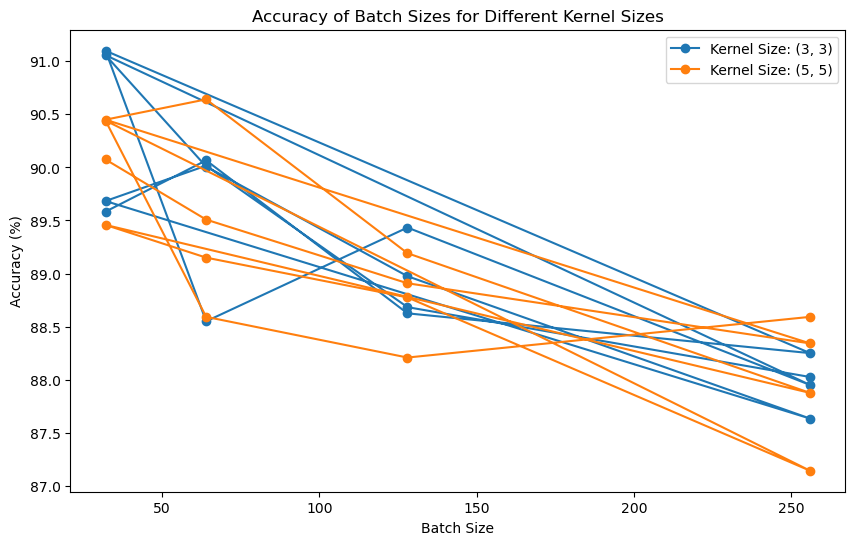

In [32]:
plt.figure(figsize=(10, 6))
for kernel_size in results_df['kernel_size'].unique():
    subset = results_df[results_df['kernel_size'] == kernel_size]
    plt.plot(
        subset['batch_size'], 
        subset['accuracy'], 
        marker='o', 
        label=f'Kernel Size: {kernel_size}'
    )
plt.xlabel("Batch Size")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy of Batch Sizes for Different Kernel Sizes")
plt.legend()
plt.show()

- Accuracy decreased as batch size got larger. 3x3 with batch size 64 decreased in accuracy greatly but improved with batch size of 128

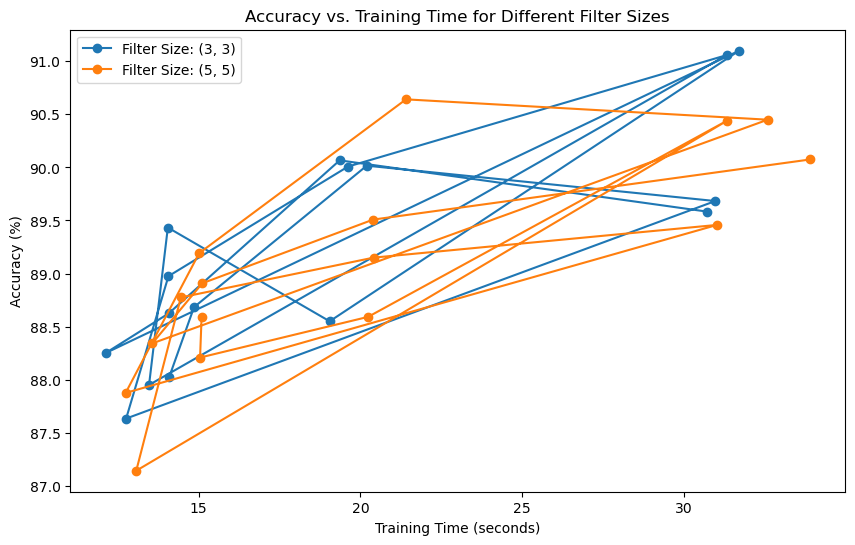

In [33]:
plt.figure(figsize=(10, 6))
for kernel_size in results_df['kernel_size'].unique():
    subset = results_df[results_df['kernel_size'] == kernel_size]
    plt.plot(
        subset['time'],
        subset['accuracy'],
        marker='o', 
        label=f'Filter Size: {kernel_size}'
    )
plt.xlabel("Training Time (seconds)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Training Time for Different Filter Sizes")
plt.legend()
plt.show()

The most accurate models took the longest to train. 30s>

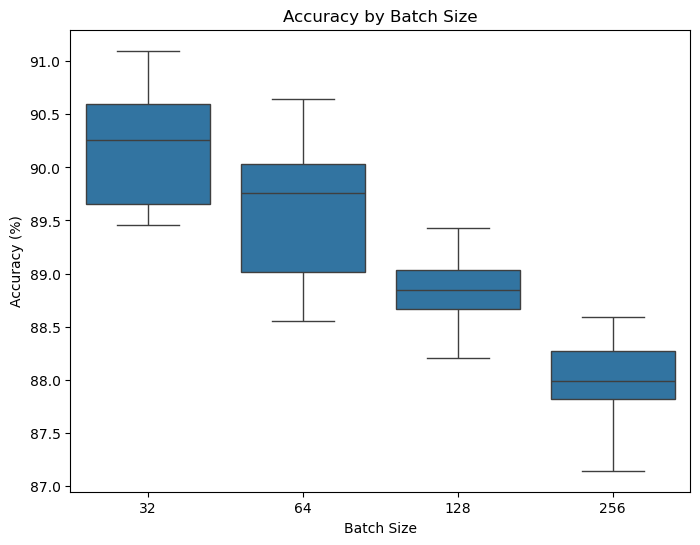

In [38]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='batch_size', 
    y='accuracy', 
    data=results_df
)
plt.xlabel("Batch Size")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Batch Size")
plt.show()

Backs up that with this data, batch size 32 is the most accurate, but batch size 128 is the most consistent with accuracy. 

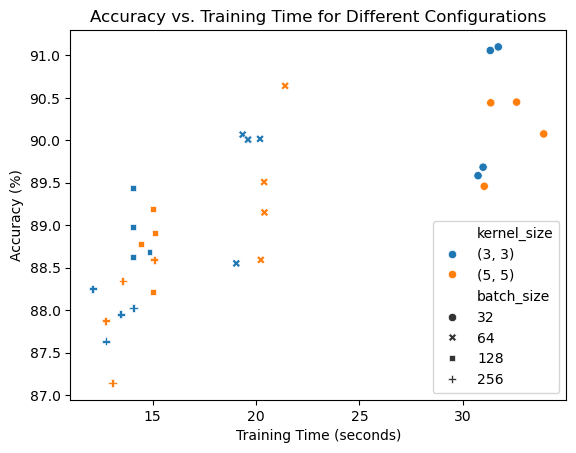

In [35]:
sns.scatterplot(
    data=results_df, 
    x='time', 
    y='accuracy', 
    hue='kernel_size', 
    style='batch_size'
)
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Training Time for Different Configurations')
plt.legend()
plt.show()

- This plot shows the accuracy compared to training time for the different configurations of batch and kernel size. 

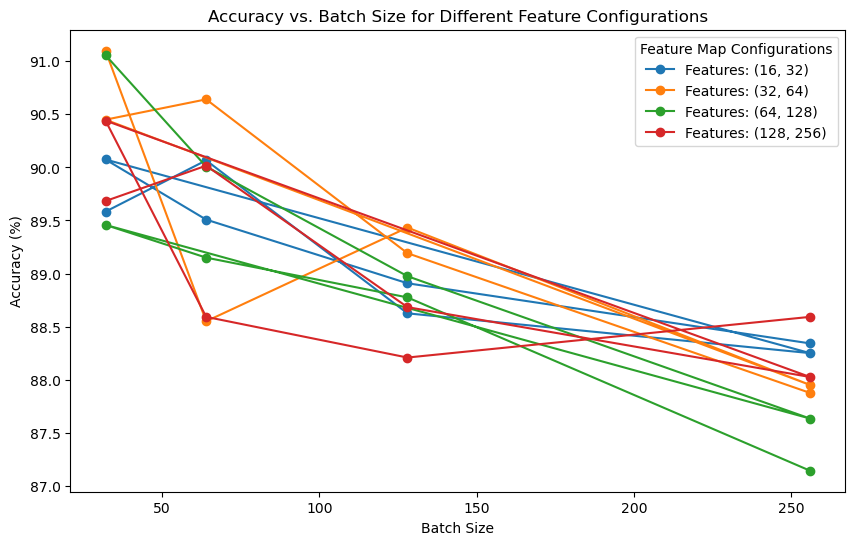

In [40]:
plt.figure(figsize=(10, 6))
for features in results_df['features'].unique():
    subset = results_df[results_df['features'] == features]
    plt.plot(subset['batch_size'], subset['accuracy'], marker='o', label=f'Features: {features}')
    
plt.xlabel("Batch Size")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Batch Size for Different Feature Configurations")
plt.legend(title="Feature Map Configurations")
plt.show()

Analysis
- 

- Accuracy and time of baseline model: ~90.49% in ~23 seconds

Experimentation was done with the following parameters:
- batch_sizes = 32, 64, 128, 256
- kernel_sizes = (3, 3), (5 ,5)
- features = (16, 32), (32, 64), (64, 128), (128, 256)

Batch size:
- The number of data samples sent to the model at a time. The higher the batch size the faster the compute time, but with a loss in accuracy. I wanted to experiment and went up to 256

Kernel size: 
- The size/dimensions of the filters 3x3 or 5x5. Smaller filters get the finer details, while larger ones are better at picking up broader patterns.

Features:
- They are in tuples. The first number is the number of output channels in the first convolutional layer, and the second number id the output of the second convolutional layer. With more features, the model can pick up on more details. 

The most accurate model was 
Batch size: 32 
Kernel size: (3, 3)
Features: (32, 64)  
It had 91.100% accuracy in  31.706968s